In [ ]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import scipy as sp

from scipy import stats
from scipy.special import expit as logistic

warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## 1. Beta distribution

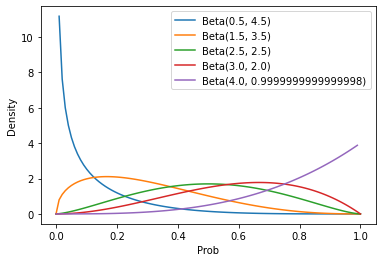

In [ ]:
x = np.linspace(0, 1, 100)
pbars = [0.1, 0.3, 0.5, 0.6, 0.8]
thetas = [5, 5, 5, 5, 5]
for pbar, theta in zip(pbars, thetas):
    y = sp.stats.beta.pdf(x[:, np.newaxis], pbar * theta, (1-pbar) * theta)
    plt.plot(x, y, label=f"Beta({pbar * theta}, {(1 - pbar) * theta})")

plt.xlabel("Prob")
plt.ylabel("Density")
plt.legend();

## 2. UCB admissions

In [ ]:
d = pd.read_csv("./data/UCBadmit.csv", sep=";")
d.shape

(12, 5)

In [ ]:
d.head()

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325


In [ ]:
gid = pd.Categorical(d["applicant.gender"]).codes
N = d["applications"].values

In [ ]:
with pm.Model() as adm1:
    
    a = pm.Normal("a", 0, 1.5, shape=2)
    p = pm.Deterministic("p", pm.math.invlogit(a[gid]))
    phi = pm.Exponential("phi",1.0)
    theta = pm.Deterministic("theta", 2 + phi)
    
    admit = pm.BetaBinomial("admit", p * theta, (1-p)*theta, N, 
                            observed=d.admit.values)
    
    prior_adm1 = pm.sample_prior_predictive()
    trace_adm1 = pm.sample()
    posterior_adm1 = pm.sample_posterior_predictive(trace_adm1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6893075905516008, but should be close to 0.8. Try to increase the number of tuning steps.


In [ ]:
az.summary(trace_adm1, var_names=["a", "phi", "theta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.316,0.422,-1.065,0.496,0.009,0.007,2148.0,1817.0,2150.0,1847.0,1.0
a[1],-0.441,0.401,-1.223,0.276,0.008,0.006,2568.0,2184.0,2581.0,2368.0,1.0
phi,1.023,0.767,0.001,2.432,0.016,0.011,2422.0,2422.0,1879.0,1411.0,1.0
theta,3.023,0.767,2.001,4.432,0.016,0.011,2422.0,2422.0,1879.0,1411.0,1.0


In [ ]:
diff_a = trace_adm1["a"][:, 0] - trace_adm1["a"][:, 1]
diff_p = logistic(trace_adm1["a"][:, 0]) - logistic(trace_adm1["a"][:, 1])
az.summary({"diff_a": diff_a, "diff_p": diff_p}, 
           kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
diff_a,0.13,0.57,-0.91,1.19
diff_p,0.03,0.13,-0.21,0.27


In [ ]:
pp_admit = posterior_adm1["admit"] / N
pp_admit.shape

(4000, 12)

/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)
/opt/conda/lib/python3.7/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)


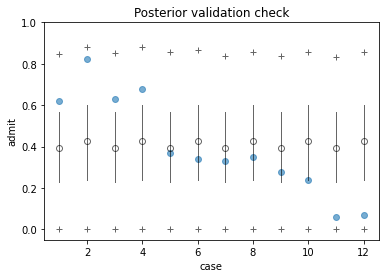

In [ ]:
plt.plot(range(1, 13), d.admit / N, "C0o", ms=6, alpha=0.6)
plt.plot(range(1, 13), trace_adm1["p"].mean(0), "ko", fillstyle="none", ms=6, alpha=0.6)
plt.plot([range(1, 13), range(1, 13)], az.hpd(trace_adm1["p"][None, :]).T, "k-", lw=1, alpha=0.6)
plt.plot([range(1, 13), range(1, 13)], az.hpd(pp_admit[None, :]).T, "k+", ms=6, alpha=0.6)

plt.xlabel("case")
plt.ylabel("admit")
plt.title("Posterior validation check")
plt.ylim(-0.05, 1);

## 3. The Oceanic tools

In [ ]:
d = pd.read_csv("./data/Kline.txt", sep=";")
d.shape

(10, 5)

In [ ]:
d

,culture,population,contact,total_tools,mean_TU
0,Malekula,1100,low,13,3.2
1,Tikopia,1500,low,22,4.7
2,Santa Cruz,3600,low,24,4.0
3,Yap,4791,high,43,5.0
4,Lau Fiji,7400,high,33,5.0
5,Trobriand,8000,high,19,4.0
6,Chuuk,9200,high,40,3.8
7,Manus,13000,low,28,6.6
8,Tonga,17500,high,55,5.4
9,Hawaii,275000,low,71,6.6


In [ ]:
def standardize(s):
    return (s - s.mean()) / s.std()

In [ ]:
d.head()

,culture,population,contact,total_tools,mean_TU
0,Malekula,1100,low,13,3.2
1,Tikopia,1500,low,22,4.7
2,Santa Cruz,3600,low,24,4.0
3,Yap,4791,high,43,5.0
4,Lau Fiji,7400,high,33,5.0


In [ ]:
P = standardize(np.log(d.population)).values
P = P + np.abs(P.min()) + 0.1 # must be > 0
cid = pd.Categorical(d.contact).codes

In [ ]:
import theano.tensor as tt

In [ ]:
with pm.Model() as tool1:
    a = pm.Normal("a", 1.0, 1.0, shape=2)
    b = pm.Exponential("b", 1.0, shape=2)
    g = pm.Exponential("g", 1.0)
    phi = pm.Exponential("phi", 1.0)
    
    lam = (tt.exp(a[cid]) * P ** b[cid]) / g
    
    tools = pm.NegativeBinomial("tool", lam, phi, 
                                observed=d.total_tools)
    
    prior_t1 = pm.sample_prior_predictive()
    trace_t1 = pm.sample()
    posterior_t1 = pm.sample_posterior_predictive(trace_t1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, g, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [ ]:
az.summary(trace_t1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],1.355,0.723,-0.014,2.672,0.021,0.015,1201.0,1178.0,1203.0,1539.0,1.0
a[1],1.435,0.719,-0.003,2.700,0.022,0.015,1101.0,1101.0,1102.0,1468.0,1.0
b[0],0.742,0.612,0.000,1.858,0.014,0.010,1982.0,1982.0,1399.0,924.0,1.0
b[1],0.390,0.194,0.008,0.706,0.005,0.003,1695.0,1695.0,1459.0,815.0,1.0
g,0.169,0.138,0.016,0.402,0.004,0.003,1049.0,974.0,1093.0,1476.0,1.0
phi,3.389,1.485,0.852,6.144,0.043,0.033,1182.0,1017.0,1286.0,1055.0,1.0


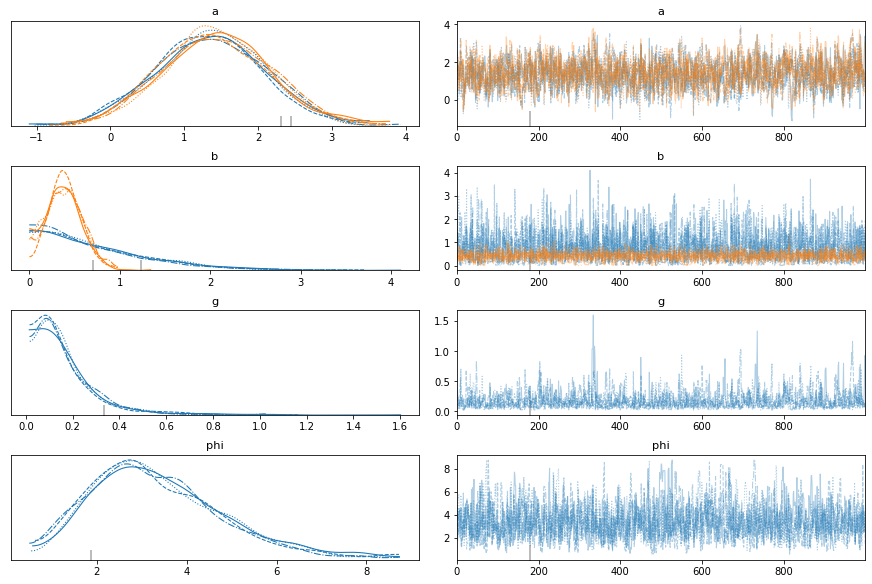

In [ ]:
az.plot_trace(trace_t1, compact=True);

## 3. Drink data simulation

In [ ]:
PROB_DRINK = 0.2 # 20% days drinking
RATE_WORK = 1.0 # Average 1 manuscript per day
N = 365 # days = One year

# Simulate days monk drink
drink = np.random.binomial(n=1, p=PROB_DRINK, size=N)
# Simulate manuscripts completed
y = (1 - drink) * np.random.poisson(RATE_WORK, size=N)

In [ ]:
len(drink)

365

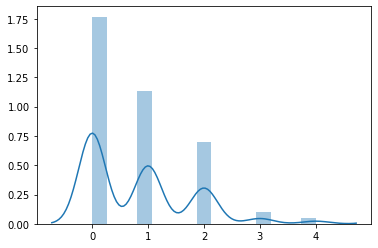

In [ ]:
import seaborn as sns

sns.distplot(y)

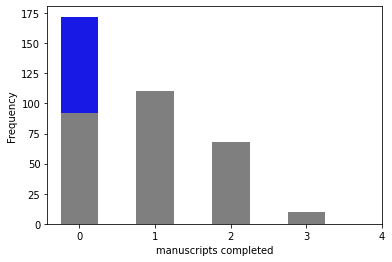

In [ ]:
zeros_drink = drink.sum()
zeros_work = (y == 0).sum() - zeros_drink

bins = np.arange(y.max() + 1) - 0.5
plt.hist(y, bins=bins, align="mid", rwidth=.5, color="k", alpha=0.5)
plt.bar(0.0, zeros_drink, bottom=zeros_work, width=.5, color="b", alpha=0.8)
plt.xticks(bins + 0.5)
plt.xlabel("manuscripts completed")
plt.ylabel("Frequency");


In [ ]:
with pm.Model() as drk:
    ap = pm.Normal("ap", -1.5, 1.0)
    al = pm.Normal("al", 1.0, 0.5)
    p = pm.math.invlogit(ap)
    lambda_ = pm.math.exp(al)
    
    y_obs = pm.ZeroInflatedPoisson("y_obs", 1.0-p, lambda_, observed=y)
    trace_drk = pm.sample(tune=2000)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [al, ap]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.8942002962036256, but should be close to 0.8. Try to increase the number of tuning steps.


In [ ]:
az.summary(trace_drk)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
ap,-1.957,0.537,-2.970,-1.088,0.017,0.013,1017.0,906.0,1107.0,1293.0,1.01
al,-0.052,0.085,-0.214,0.098,0.002,0.002,1208.0,1208.0,1209.0,1274.0,1.01


In [ ]:
logistic(trace_drk["ap"]).mean()  # probability drink

0.13447916253739467

In [ ]:
np.exp(trace_drk["al"]).mean()  # rate finish manuscripts, when not drinking

0.9529980058997166

## 4. Trolly data - ordered categorical outcomes

In [ ]:
d = pd.read_csv("./data/Trolley.csv", sep=";")
d.shape

(9930, 12)

In [ ]:
d.head()

,case,response,order,id,age,male,edu,action,intention,contact,story,action2
0,cfaqu,4,2,96;434,14,0,Middle School,0,0,1,aqu,1
1,cfbur,3,31,96;434,14,0,Middle School,0,0,1,bur,1
2,cfrub,4,16,96;434,14,0,Middle School,0,0,1,rub,1
3,cibox,3,32,96;434,14,0,Middle School,0,1,1,box,1
4,cibur,3,4,96;434,14,0,Middle School,0,1,1,bur,1


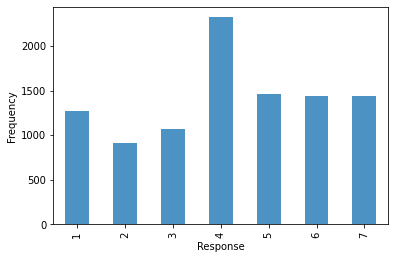

In [ ]:
ax = d.response.value_counts(sort=False).plot(kind="bar", alpha=0.8)
ax.set_xlabel("Response")
ax.set_ylabel("Frequency");

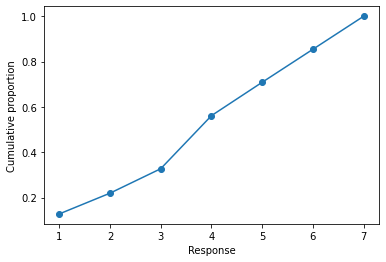

In [ ]:
ax = d.response.value_counts(normalize=True, sort=False).cumsum().plot(marker="o");
ax.set_xlabel("Response")
ax.set_ylabel("Cumulative proportion");

In [ ]:
d.response.value_counts(normalize=True, sort=False).cumsum()

1    0.128298
2    0.219839
3    0.327694
4    0.561631
5    0.708862
6    0.854381
7    1.000000
Name: response, dtype: float64

In [ ]:
import scipy
lco = d.response.value_counts(normalize=True, sort=False).cumsum().apply(scipy.special.logit)
lco.round(2)

1   -1.92
2   -1.27
3   -0.72
4    0.25
5    0.89
6    1.77
7     NaN
Name: response, dtype: float64

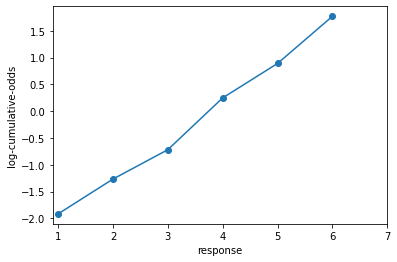

In [ ]:
ax = lco.plot(marker="o")
ax.set_xlim(0.9, 7)
ax.set_xlabel("response")
ax.set_ylabel("log-cumulative-odds");

In [ ]:
with pm.Model() as trl1:
    cutpoints = pm.Normal("cutpoints", 0.0, 1.5,
                         transform=pm.distributions.transforms.ordered,
                         shape=6, testval=np.arange(6) - 2.5)
    response = pm.OrderedLogistic("response", 0.0, cutpoints,
                                 observed=d.response - 1)
    
    trace_trl1 = pm.sample()
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [ ]:
az.summary(trace_trl1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
cutpoints[0],-1.917,0.030,-1.973,-1.860,0.0,0.0,3991.0,3984.0,3987.0,2664.0,1.0
cutpoints[1],-1.267,0.025,-1.313,-1.222,0.0,0.0,4335.0,4320.0,4335.0,3172.0,1.0
cutpoints[2],-0.719,0.022,-0.759,-0.677,0.0,0.0,4203.0,4157.0,4256.0,3207.0,1.0
cutpoints[3],0.247,0.020,0.211,0.286,0.0,0.0,4314.0,4303.0,4327.0,3804.0,1.0
cutpoints[4],0.890,0.021,0.849,0.930,0.0,0.0,4586.0,4586.0,4582.0,3806.0,1.0
cutpoints[5],1.770,0.028,1.719,1.822,0.0,0.0,5216.0,5210.0,5216.0,3890.0,1.0


In [ ]:
logistic(trace_trl1["cutpoints"]).mean(0).round(3)

array([0.128, 0.22 , 0.328, 0.562, 0.709, 0.854])

In [ ]:
logistic(trace_trl1["cutpoints"]).std(0).round(3)

array([0.003, 0.004, 0.005, 0.005, 0.004, 0.003])

In [ ]:
def ordered_logistic_proba(a):
    p_cum = logistic(a)
    p_cum = np.concatenate(([0.0], p_cum, [1.0]))

    return p_cum[1:] - p_cum[:-1]


pk = ordered_logistic_proba(trace_trl1["cutpoints"].mean(axis=0))
pk.round(2), pk.sum()

(array([0.13, 0.09, 0.11, 0.23, 0.15, 0.15, 0.15]), 1.0)

In [ ]:
with pm.Model() as trl2:
    
    
    cutpoints = pm.Normal("cutpoints", 0.0, 1.5,
                         transform=pm.distributions.transforms.ordered,
                         shape=6, testval=np.arange(6) - 2.5)
    
    bA = pm.Normal("bA", 0.0, 0.5)
    bC = pm.Normal("bC", 0.0, 0.5)
    bI = pm.Normal("bI", 0.0, 0.5)
    bIA = pm.Normal("bIA", 0.0, 0.5)
    bIC = pm.Normal("bIC", 0.0, 0.5)

    A = pm.Data("A", d.action.values)
    I = pm.Data("I", d.intention.values)
    C = pm.Data("C", d.contact.values)

    BI = bI + bIA * A + bIC * C
    phi = pm.Deterministic("phi", bA * A + bC * C + BI * I)
    
    response = pm.OrderedLogistic("response", phi, cutpoints,
                                 observed=d.response - 1)
    
    trace_trl2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bIC, bIA, bI, bC, bA, cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 88 seconds.


In [ ]:
az.summary(trace_trl2, var_names=["bIC", "bIA", "bC", "bI", "bA"])

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (1,9930) (1,6) 
Apply node that caused the error: AdvancedSubtensor(InplaceDimShuffle{1,0}.0, TensorConstant{[[3 2 3 ... 6 1 1]]}, InplaceDimShuffle{x,0}.0)
Toposort index: 36
Inputs types: [TensorType(float64, matrix), TensorType(int64, row), TensorType(int64, row)]
Inputs shapes: [(7, 6), (1, 9930), (1, 6)]
Inputs strides: [(8, 56), (79440, 8), (48, 8)]
Inputs values: ['not shown', 'not shown', 'not shown']
Outputs clients: [[Elemwise{Composite{Switch(i0, log(i1), i2)}}[(0, 1)](Elemwise{Composite{Cast{int8}((i0 * i1))}}.0, AdvancedSubtensor.0, TensorConstant{(1, 1) of -inf})]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3254, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-68-3754ed2fd19f>", line 22, in <module>
    observed=d.response - 1)
  File "/home/jovyan/pymc3/distributions/distribution.py", line 83, in __new__
    return model.Var(name, dist, data, total_size, dims=dims)
  File "/home/jovyan/pymc3/model.py", line 1117, in Var
    model=self,
  File "/home/jovyan/pymc3/model.py", line 1740, in __init__
    self.logp_elemwiset = distribution.logp(data)
  File "/home/jovyan/pymc3/distributions/discrete.py", line 1038, in logp
    value_clip,
  File "/home/jovyan/pymc3/theanof.py", line 553, in take_along_axis
    return arr[_make_along_axis_idx(arr_shape, indices, _axis)]

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [ ]:
az.plot_forest(trace_trl2, combined=True, figsize=(5, 3),
               var_names=["bIC", "bIA", "bC", "bI", "bA"]);

In [ ]:
# Observed cum probs:
p_obs = (
    d.groupby(["action", "contact", "intention"])
    .response.value_counts(normalize=True, sort=False)
    .unstack()
    .cumsum(axis=1)
    .iloc[:, :-1]
)

p_obs.columns = range(6)
p_obs

0         1         2         3         4  \
action contact intention                                                     
0      0       0          0.050755  0.112991  0.187915  0.443505  0.596375   
               1          0.070997  0.155589  0.251259  0.514602  0.652064   
       1       0          0.092649  0.150050  0.249748  0.497482  0.677744   
               1          0.336354  0.497482  0.645519  0.791541  0.880161   
1      0       0          0.100831  0.179003  0.285876  0.535876  0.709215   
               1          0.215106  0.344411  0.482175  0.677946  0.804834   

                                 5  
action contact intention            
0      0       0          0.779456  
               1          0.820242  
       1       0          0.856999  
               1          0.942598  
1      0       0          0.863293  
               1          0.901511

In [ ]:
# Counterfactual cases:
cases_df = pd.DataFrame(
    np.array([[0, 0, 0], [0, 0, 1], [1, 0, 0], [1, 0, 1], [0, 1, 0], [0, 1, 1]]),
    columns=["action", "contact", "intention"],
)
cases_df

,action,contact,intention
0,0,0,0
1,0,0,1
2,1,0,0
3,1,0,1
4,0,1,0
5,0,1,1


In [ ]:
with trl2:
    pm.set_data(
        {
            "A": cases_df.action.values,
            "C": cases_df.contact.values,
            "I": cases_df.intention.values,
        }
    )
    pp_phi = pm.sample_posterior_predictive(trace_trl2, var_names=["phi"])[
        "phi"
    ]

In [ ]:
def p_ord_logit(responses: range, phi: np.ndarray, a: np.ndarray):
    """
    For the given posterior sample, computes the cumulative probabilities
    of each response in each of the counterfactual values of the predictors.

    responses: range of possible responses in the experiment
    phi: posterior phi for each counterfactual case
    a: posterior intercept for each response
    """
    p = pd.DataFrame(index=range(len(cases_df)), columns=responses)
    for case in p.index:
        p.loc[case] = logistic(a - phi[case])

    p = pd.concat([cases_df, p], axis=1).set_index(["action", "contact", "intention"]).sort_index()
    p.index.name = "case"
    p.columns.name = "response"

    return p

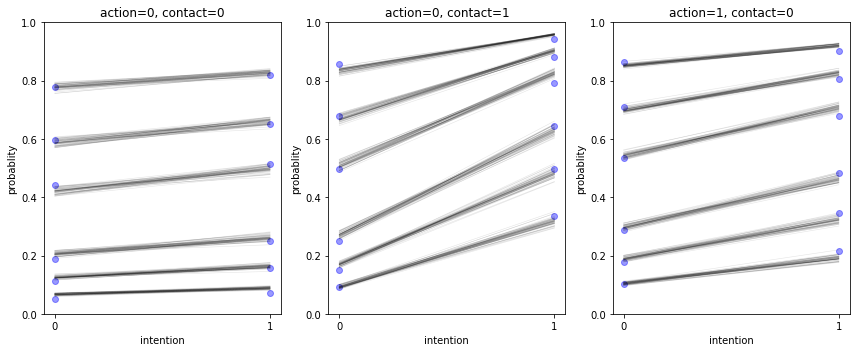

In [ ]:
_, axes = plt.subplots(1, 3, figsize=(12, 5))

for s in range(50):
    p = p_ord_logit(responses=range(6), phi=pp_phi[s], a=trace_trl2["cutpoints"][s])

    cur_ax = 0
    for (action, contact), _ in p.groupby(level=["action", "contact"]):
        axes[cur_ax].plot([0, 1], p.loc[action, contact], lw=0.6, c="k", alpha=0.1)

        if s == 0:
            axes[cur_ax].plot([0, 1], p_obs.loc[action, contact], "ob", alpha=0.4)
            axes[cur_ax].set_xticks([0, 1])
            axes[cur_ax].set_xlabel("intention")
            axes[cur_ax].set_ylabel("probablity")
            axes[cur_ax].set_ylim([0, 1])
            axes[cur_ax].set_title(f"action={action}, contact={contact}")

        cur_ax += 1
plt.tight_layout()

In [ ]:
with trl2:
    pp_resp = pm.sample_posterior_predictive(
        trace_trl2, var_names=["response"])["response"]

resp_df = pd.DataFrame(pp_resp).T
resp_df.index.name = "case"
resp_df = (
    pd.concat([cases_df, resp_df], axis=1)
    .set_index(["action", "contact", "intention"])
    .sort_index()
)
resp_df

0     1     2     3     4     5     6     7     \
action contact intention                                                   
0      0       0             0     4     1     4     0     4     5     3   
               1             5     2     2     2     4     5     3     5   
       1       0             5     2     5     3     4     5     5     4   
               1             4     3     3     3     3     1     4     1   
1      0       0             4     1     6     1     3     5     2     4   
               1             0     3     3     0     0     0     1     5   

                          8     9     ...  3990  3991  3992  3993  3994  3995  \
action contact intention              ...                                       
0      0       0             6     6  ...     5     3     6     5     3     5   
               1             6     6  ...     2     3     5     6     4     4   
       1       0             0     4  ...     4     1     5     4     3     3   
               1             6     3  ...     1     1     3     5     3     2   
1      0       0             3     4  ...     3     4     1     3     3     2   
               1             3     2  ...     6     2     4     3     3     5   

                          3996  3997  3998  3999  
action contact intention                          
0      0       0             3     6     4     5  
               1             4     2     2     6  
       1       0             0     6     2     6  
               1             3     0     0     4  
1      0       0             2     0     3     5  
               1             0     3     2     1  

[6 rows x 4000 columns]

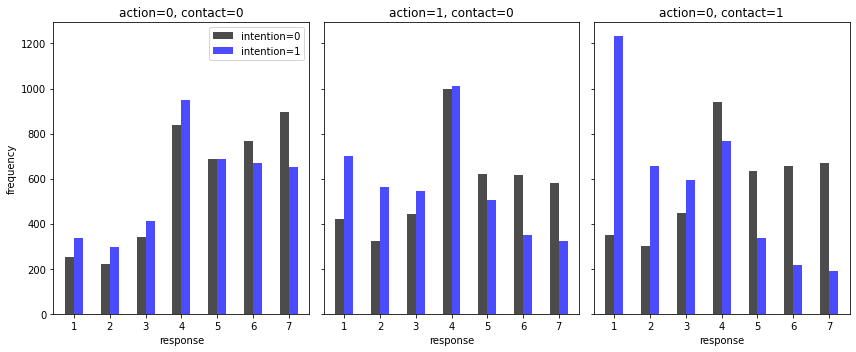

In [ ]:
_, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True)
bins, xticks, xlabels, colors = (
    np.arange(8) - 0.5,
    np.arange(7),
    np.arange(1, 8),
    ["k", "b"],
)

axes[0].hist(
    [resp_df.loc[0, 0, 0], resp_df.loc[0, 0, 1]],
    bins=bins,
    rwidth=0.5,
    label=["intention=0", "intention=1"],
    color=colors,
    alpha=0.7,
)
axes[0].set_title("action=0, contact=0")
axes[0].set_ylabel("frequency")
axes[0].legend(fontsize=10)

axes[1].hist(
    [resp_df.loc[1, 0, 0], resp_df.loc[1, 0, 1]],
    bins=bins,
    rwidth=0.5,
    color=colors,
    alpha=0.7,
)
axes[1].set_title("action=1, contact=0")

axes[2].hist(
    [resp_df.loc[0, 1, 0], resp_df.loc[0, 1, 1]],
    bins=bins,
    rwidth=0.5,
    color=colors,
    alpha=0.7,
)
axes[2].set_title("action=0, contact=1")

for ax in axes:
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)
    ax.set_xlabel("response")
plt.tight_layout();

## 5. Trolly data - ordered categorical predictors

In [ ]:
d = pd.read_csv("data/Trolley.csv", delimiter=";")
d.shape

(9930, 12)

In [ ]:
d.head()

,case,response,order,id,age,male,edu,action,intention,contact,story,action2
0,cfaqu,4,2,96;434,14,0,Middle School,0,0,1,aqu,1
1,cfbur,3,31,96;434,14,0,Middle School,0,0,1,bur,1
2,cfrub,4,16,96;434,14,0,Middle School,0,0,1,rub,1
3,cibox,3,32,96;434,14,0,Middle School,0,1,1,box,1
4,cibur,3,4,96;434,14,0,Middle School,0,1,1,bur,1


In [ ]:
d["edu_new"] = pd.Categorical(
    d.edu.values,
    categories=[
        "Elementary School",
        "Middle School",
        "Some High School",
        "High School Graduate",
        "Some College",
        "Bachelor's Degree",
        "Master's Degree",
        "Graduate Degree",
    ],
    ordered=True,
)
d["edu_new"] = d.edu_new.cat.codes

In [ ]:
d["edu_new"].value_counts()

5    3540
4    2460
6    1410
7    1050
3     870
2     420
1     120
0      60
Name: edu_new, dtype: int64

In [ ]:
np.repeat(2.0, 7)

array([2., 2., 2., 2., 2., 2., 2.])

In [ ]:
delta = np.random.dirichlet(np.repeat(2.0, 7), size=10)
delta.shape

(10, 7)

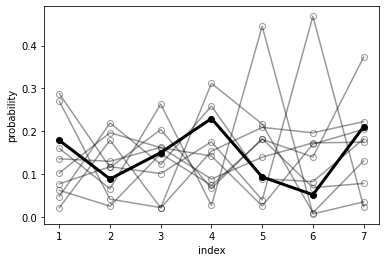

In [ ]:
plt.plot(np.stack([range(1, 8)] * 9).T, delta[1:].T, "-ok", alpha=0.4, fillstyle="none")
plt.plot(np.arange(1, 8).T, delta[0].T, "-ok", lw=3, ms=6)
plt.xlabel("index")
plt.ylabel("probability");

In [ ]:
R = d.response.values - 1
A = d.action.values
I = d.intention.values
C = d.contact.values
E = d.edu_new.values

with pm.Model() as trl3:
    kappa = pm.Normal("kappa", 0.0, 1.5, shape=6, 
                      transform=pm.distributions.transforms.ordered,
                      testval=np.arange(6))
    
    bA = pm.Normal("bA", 0.0, 0.5)
    bC = pm.Normal("bC", 0.0, 0.5)
    bI = pm.Normal("bI", 0.0, 0.5)
    bE = pm.Normal("bE", 0.0, 0.5)
    
    delta = pm.Dirichlet("delta", np.repeat(2.0, 7), shape=7)
    delta_j = tt.concatenate([tt.zeros(1), delta])
    delta_j_cumulative = tt.cumsum(delta_j)
    
    phi = bE * delta_j_cumulative[E] + bA*A + bC*C + bI*I
    
    resp_obs = pm.OrderedLogistic("resp_obs", phi, kappa, observed=R)
    trace_trl3 = pm.sample(2000, tune=2000, target_accept=0.9)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta, bE, bI, bC, bA, kappa]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 562 seconds.


In [ ]:
az.summary(trace_trl3, var_names=["bA", "bC", "bI", "bE", "delta"], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bA,-0.70,0.04,-0.77,-0.62,0.0,0.0,10923.92,10923.92,10922.13,6718.36,1.0
bC,-0.95,0.05,-1.04,-0.85,0.0,0.0,9081.62,9081.62,9092.90,6326.91,1.0
bI,-0.71,0.04,-0.78,-0.65,0.0,0.0,10837.87,10837.87,10847.57,5959.58,1.0
bE,-0.29,0.16,-0.61,-0.02,0.0,0.0,3670.74,3203.09,3906.21,3746.04,1.0
delta[0],0.22,0.13,0.01,0.45,0.0,0.0,5749.52,5372.98,5721.97,5112.92,1.0
delta[1],0.14,0.09,0.01,0.30,0.0,0.0,9842.10,7150.75,8939.61,4312.94,1.0
delta[2],0.19,0.11,0.01,0.38,0.0,0.0,10892.90,9868.17,9987.39,5175.10,1.0
delta[3],0.17,0.10,0.01,0.35,0.0,0.0,10091.08,8285.80,9771.22,6139.16,1.0
delta[4],0.05,0.05,0.00,0.12,0.0,0.0,3706.46,3435.66,6095.57,3949.50,1.0
delta[5],0.10,0.07,0.00,0.22,0.0,0.0,7363.47,6108.43,7662.89,5736.63,1.0


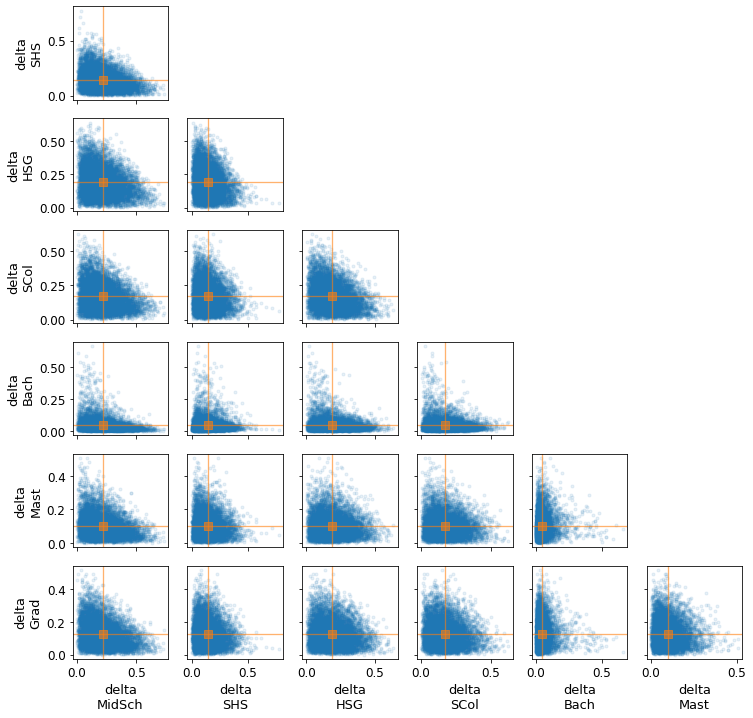

In [ ]:
idata = az.from_pymc3(trace_trl3)

idata.posterior.coords["delta_dim_0"] = [
    "MidSch",
    "SHS",
    "HSG",
    "SCol",
    "Bach",
    "Mast",
    "Grad",
]

az.plot_pair(
    idata,
    var_names=["delta"],
    #diagonal=True,
    point_estimate="mean",
    textsize=12,
    figsize=(12, 12),
    scatter_kwargs={"alpha": 0.1},
    point_estimate_kwargs={"alpha": 0.6, "lw": 1.3},
    point_estimate_marker_kwargs={"alpha": 0.6},
);